In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam as adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
import numpy as np
from pathlib import Path
from itertools import product as myzip

In [2]:
my_path = 'D:\keras_png_slices_data\keras_png_slices_'
datasets = ['train', 'validate', 'test']
pixels = [0, 85, 170, 255]
data_dict = {}

In [3]:
def format_fn(path):
    img = tf.io.read_file(path)
    
    return tf.image.decode_png(img)

def path_2_tens(x_path, y_path):
    x = format_fn(x_path)
    x = tf.cast(x, tf.float32)/127.5 - 1.0
    
    y = format_fn(y_path)
    y = tf.reshape(y, [256, 256])
    y = tf.stack([y==pixel for pixel in pixels], axis=2)
    y = tf.cast(y, tf.float32)
    
    return x, y

In [5]:
for dataset in datasets:
    x_paths = glob.glob(my_path + dataset + '\*.png')
    y_paths = glob.glob(my_path + 'seg_' + dataset + '\*.png')
    data_dict[dataset] = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    data_dict[dataset] = data_dict[dataset].map(path_2_tens)

x_sample, y_sample = next(iter(data_dict['train'].batch(3)))

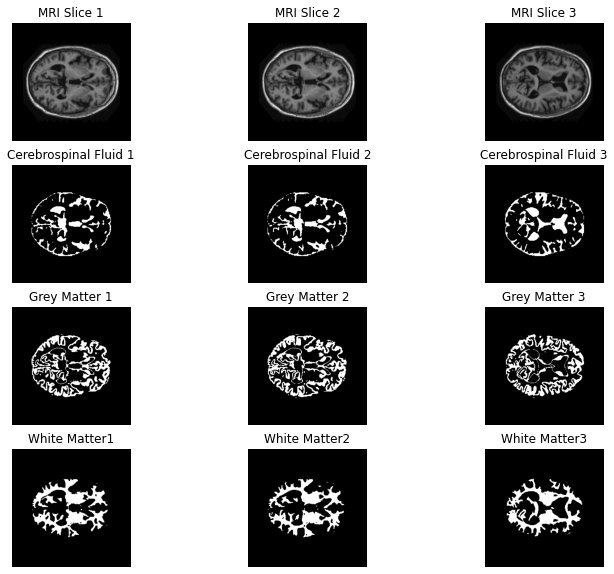

In [15]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter']

for i, j in myzip(range(3), range(1, 4)):
    ax[0][i].imshow(x_sample[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title('MRI Slice ' + str(i+1))
    
    ax[j][i].imshow(y_sample[i, :, :, j], cmap='gray')
    ax[j][i].axis('off')
    ax[j][i].set_title(labels[j-1] + str(i+1))
    
plt.show()